In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from htc.fonts.set_font import set_font
from htc.settings_seg import settings_seg
from htc_projects.context.models.context_evaluation import baseline_granularity_comparison
from htc_projects.context.settings_context import settings_context

In [2]:
np.random.seed(42)
df = baseline_granularity_comparison(
    baseline_timestamp=settings_seg.model_comparison_timestamp,
    glove_runs_hsi=settings_context.glove_runs_granularities,
    glove_runs_rgb=settings_context.glove_runs_granularities_rgb,
)
df.head()

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:481
/mnt/ssd_8tb/htc/results_semantic/training/pixel/2022-02-03_22-58-44_generated_default_model_comparison                 

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:481
/mnt/ssd_8tb/htc/results_semantic/training/pixel/2022-02-03_22-58-44_generated_default_rgb_model_compari                
son                                                                                                                     

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:481
/mnt/ssd_8tb/htc/results_context/training/superpixel_classification/2024-07-24_15-20-46_default                         

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:481
/mnt/ssd_8tb/htc/results_context/training/superpixel_classification/2024-07-24_15-20-46_default_rgb                     

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:481
/mnt/ssd_8tb/htc/results_semantic/training/patch/2022-02-03_22-58-44_generated_default_model_comparison                 

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:481
/mnt/ssd_8tb/htc/results_semantic/training/patch/2022-02-03_22-58-44_generated_default_rgb_model_compari                
son                                                                                                                     

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:481
/mnt/ssd_8tb/htc/results_semantic/training/patch/2022-02-03_22-58-44_generated_default_64_model_comparis                
on                                                                                                                      

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:481
/mnt/ssd_8tb/htc/results_semantic/training/patch/2022-02-03_22-58-44_generated_default_64_rgb_model_comp                
arison                                                                                                                  

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:481
/mnt/ssd_8tb/htc/results_semantic/training/image/2022-02-03_22-58-44_generated_default_model_comparison                 

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:481
/mnt/ssd_8tb/htc/results_semantic/training/image/2022-02-03_22-58-44_generated_default_rgb_model_compari                
son                                                                                                                     

,network,dataset,modality,label_index,dice_metric,dice_metric_bootstraps,surface_distance_metric,surface_distance_metric_bootstraps,surface_dice_metric_mean,surface_dice_metric_mean_bootstraps,label_name
0,pixel,semantic,HSI,6,0.412635,"[0.3606156674298373, 0.40986517878139717, 0.41...",57.681577,"[62.86567853092483, 48.97090831865104, 69.5758...",0.252864,"[0.2841684058439557, 0.30094171133045505, 0.23...",stomach
1,pixel,semantic,HSI,5,0.827066,"[0.8748935220781101, 0.8400372300734684, 0.809...",45.375091,"[38.133658000027836, 36.634664181034644, 45.42...",0.190222,"[0.19758830164192648, 0.18775828001217362, 0.1...",small_bowel
2,pixel,semantic,HSI,4,0.827302,"[0.8418877731422325, 0.8696517438825726, 0.827...",76.252277,"[61.56888569455111, 64.03975192759948, 85.2274...",0.276587,"[0.29355359112304985, 0.30809559212207527, 0.2...",colon
3,pixel,semantic,HSI,3,0.852646,"[0.83647156366475, 0.8743577365543942, 0.91119...",59.295653,"[66.57595044640794, 55.93091580064204, 41.4775...",0.248129,"[0.21391583904107506, 0.2580384921936164, 0.27...",liver
4,pixel,semantic,HSI,8,0.502975,"[0.38943406655674884, 0.5029752005154667, 0.61...",15.949090,"[15.557039449108778, 15.94908999286465, 16.341...",0.084672,"[0.07263761486038325, 0.08467181979428426, 0.0...",gallbladder


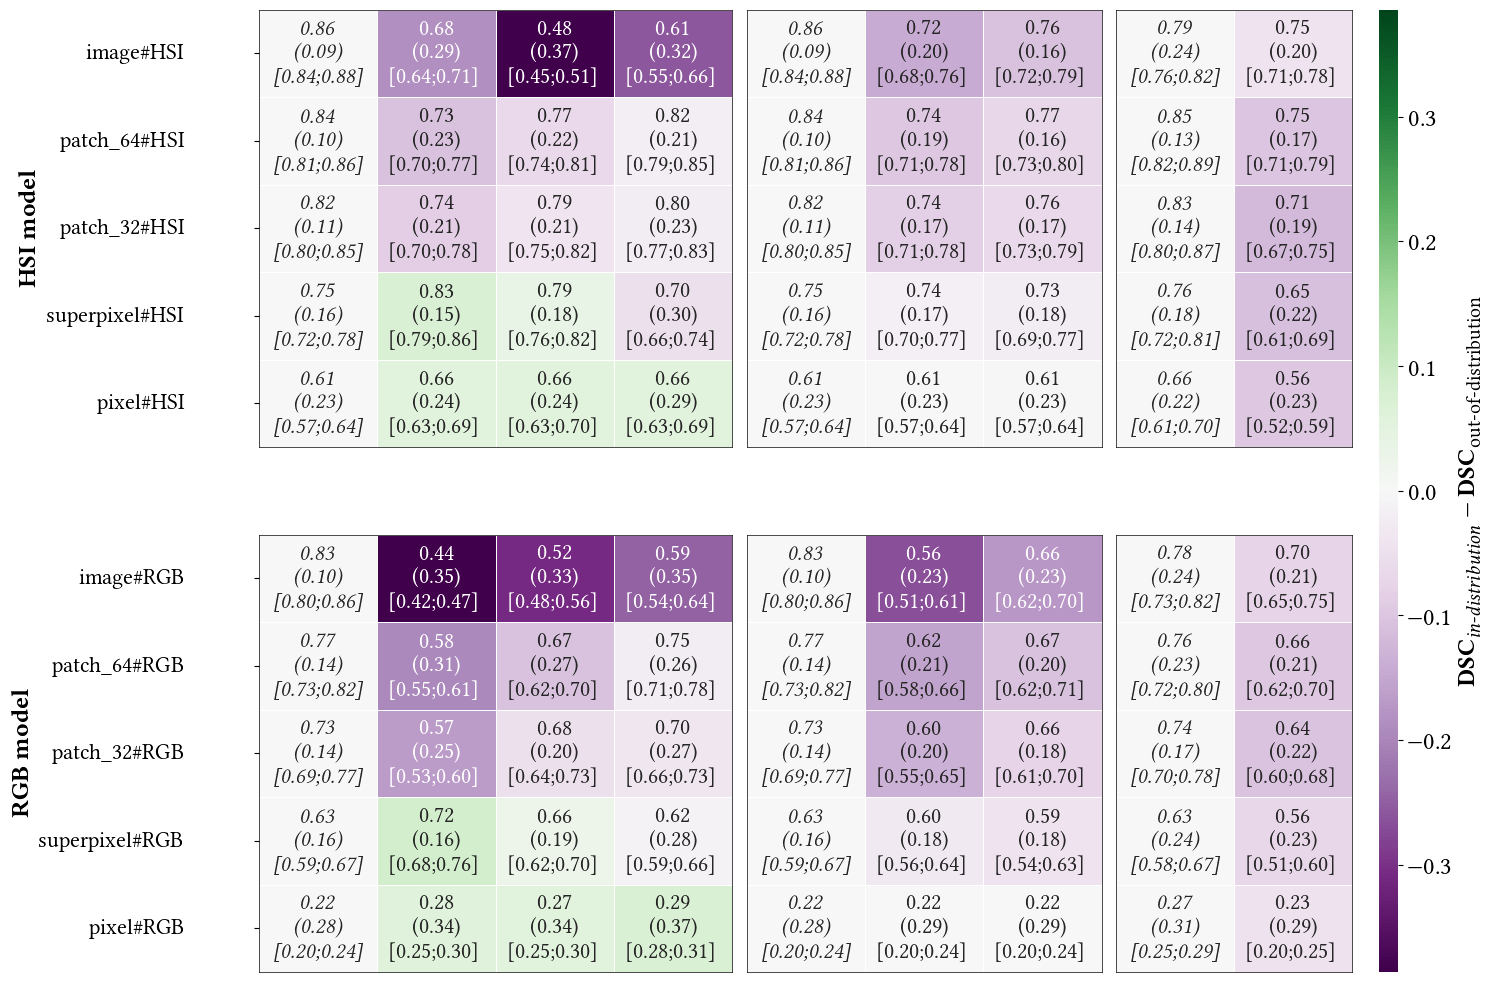

In [3]:
def granularities_comparison_figure(metric_name: str, metric_name_short: str) -> plt.Figure:
    def bootstrap_statistics(x: pd.DataFrame) -> pd.Series:
        bootstraps = np.stack(x[metric_name + "_bootstraps"])
        return pd.Series({
            "metric_mean": np.mean(np.mean(bootstraps, axis=1)),
            "metric_std": np.std(np.mean(bootstraps, axis=1)),
            "metric_ci95": np.quantile(np.mean(bootstraps, axis=0), q=[0.025, 0.975]),
        })

    df_agg = df.groupby(["network", "dataset", "modality"], as_index=False).apply(
        bootstrap_statistics, include_groups=False
    )

    # Repeat reference for removal scenario
    semantic2 = df_agg[df_agg.dataset == "semantic"].copy()
    semantic2.replace({"dataset": {"semantic": "semantic2"}}, inplace=True)
    df_agg = pd.concat([df_agg, semantic2], ignore_index=True)

    networks = list(settings_context.glove_runs_granularities.keys())
    datasets = list(settings_context.task_name_mapping.keys())
    datasets.insert(datasets.index("removal_0"), "semantic2")

    network_renaming = {
        "superpixel_classification": "superpixel",
    }

    fontsize = 18
    set_font(fontsize)
    # Text with TeX should look as close as possible as the default text with matplotlib
    plt.rcParams.update({
        "text.usetex": True,
        "text.latex.preamble": r"""
            \usepackage[T1]{fontenc}
            \usepackage{libertinus,libertinust1math}
            \usepackage{microtype}
            """,
    })
    fig, axes = plt.subplots(2, 3, figsize=(17, 12.5), gridspec_kw={"width_ratios": [4, 3, 2], "wspace": 0.04})

    for modality, axes_cols in zip(df_agg.modality.unique(), axes, strict=True):
        df_agg_modality = df_agg[df_agg.modality == modality]
        label_matrix = np.full(
            (
                len(df_agg_modality.network.unique()),
                len(df_agg_modality.dataset.unique()),
            ),
            np.nan,
        )
        label_matrix_std = np.full(
            (
                len(df_agg_modality.network.unique()),
                len(df_agg_modality.dataset.unique()),
            ),
            np.nan,
        )
        label_matrix_ci = np.full(
            (
                len(df_agg_modality.network.unique()),
                len(df_agg_modality.dataset.unique()),
                2,
            ),
            np.nan,
        )
        for _, row in df_agg_modality.iterrows():
            network_idx = networks.index(row.network)
            dataset_idx = datasets.index(row.dataset)
            label_matrix[network_idx, dataset_idx] = row.metric_mean
            label_matrix_std[network_idx, dataset_idx] = row.metric_std
            label_matrix_ci[network_idx, dataset_idx] = row.metric_ci95

        # Global diff for the shared colorbar
        diff_isolation = (
            label_matrix[:, : datasets.index("masks_isolation") + 1] - label_matrix[:, : datasets.index("semantic") + 1]
        )
        diff_removal = (
            label_matrix[:, datasets.index("semantic2") : datasets.index("removal_cloth") + 1]
            - label_matrix[:, datasets.index("semantic2") : datasets.index("semantic2") + 1]
        )
        diff_glove = (
            label_matrix[:, datasets.index("no-glove") :]
            - label_matrix[:, datasets.index("no-glove") : datasets.index("no-glove") + 1]
        )
        label_matrix_diff = np.concatenate([diff_isolation, diff_removal, diff_glove], axis=1)

        for ax, (start_idx, end_idx) in zip(
            axes_cols,
            [
                (0, datasets.index("masks_isolation")),
                (datasets.index("semantic2"), datasets.index("removal_cloth")),
                (datasets.index("no-glove"), datasets.index("glove")),
            ],
            strict=True,
        ):
            mat = label_matrix[:, start_idx : end_idx + 1]
            mat_std = label_matrix_std[:, start_idx : end_idx + 1]
            mat_ci = label_matrix_ci[:, start_idx : end_idx + 1]
            diff = mat - mat[:, :1]

            # Absolute scores in the matrix
            text = np.vectorize(
                lambda x_mean, x_std, x_ci_low, x_ci_high, base: (
                    "\\textit{"
                    + f"{x_mean:.2f}"
                    + "}\n\\textit{("
                    + f"{x_std:.2f}"
                    + ")}\n\\textit{["
                    + f"{x_ci_low:.2f}"
                    + ";"
                    + f"{x_ci_high:.2f}"
                    + "]}"
                    if base
                    else f"{x_mean:.2f}\n({x_std:.2f})\n[{x_ci_low:.2f};{x_ci_high:.2f}]"
                )
            )(mat, mat_std, mat_ci[:, :, 0], mat_ci[:, :, 1], mat == mat[:, :1])

            res = sns.heatmap(
                diff,
                annot=text,
                fmt="s",
                linewidths=0.5,
                xticklabels=False,
                yticklabels=[network_renaming.get(n, n) + "\\#" + modality for n in networks],
                annot_kws={"size": fontsize - 2},
                cmap=settings_context.cmap_diverging,
                center=0,
                vmin=-np.max(np.abs(label_matrix_diff)),
                vmax=np.max(np.abs(label_matrix_diff)),
                cbar=False,
                ax=ax,
            )

            if start_idx != 0:
                ax.set_yticks([])

            # Make frame visible
            for spine in ax.spines.values():
                spine.set_linewidth(0.5)
                spine.set_visible(True)

        axes_cols[0].tick_params(axis="y", which="major", pad=50)

        for t in axes_cols[0].yaxis.get_ticklabels():
            t.set_rotation(0)

    axes[0, 0].set_ylabel("$\\textbf{HSI model}$")
    axes[1, 0].set_ylabel("$\\textbf{RGB model}$")

    cbar = fig.colorbar(res.get_children()[0], ax=axes.ravel().tolist(), aspect=50, pad=0.02)
    cbar.set_label(
        "$\\textbf{"
        + metric_name_short
        + "}_{\\textit{in-distribution}} - \\textbf{"
        + metric_name_short
        + "}_{\\textrm{out-of-distribution}}$"
    )
    cbar.outline.set_visible(False)
    cbar.ax.tick_params(labelsize=fontsize)

    fig.savefig(
        settings_context.paper_extended_dir / f"spatial_granularities_{metric_name_short}_base.pdf", bbox_inches="tight"
    )
    return fig


granularities_comparison_figure("dice_metric", "DSC");

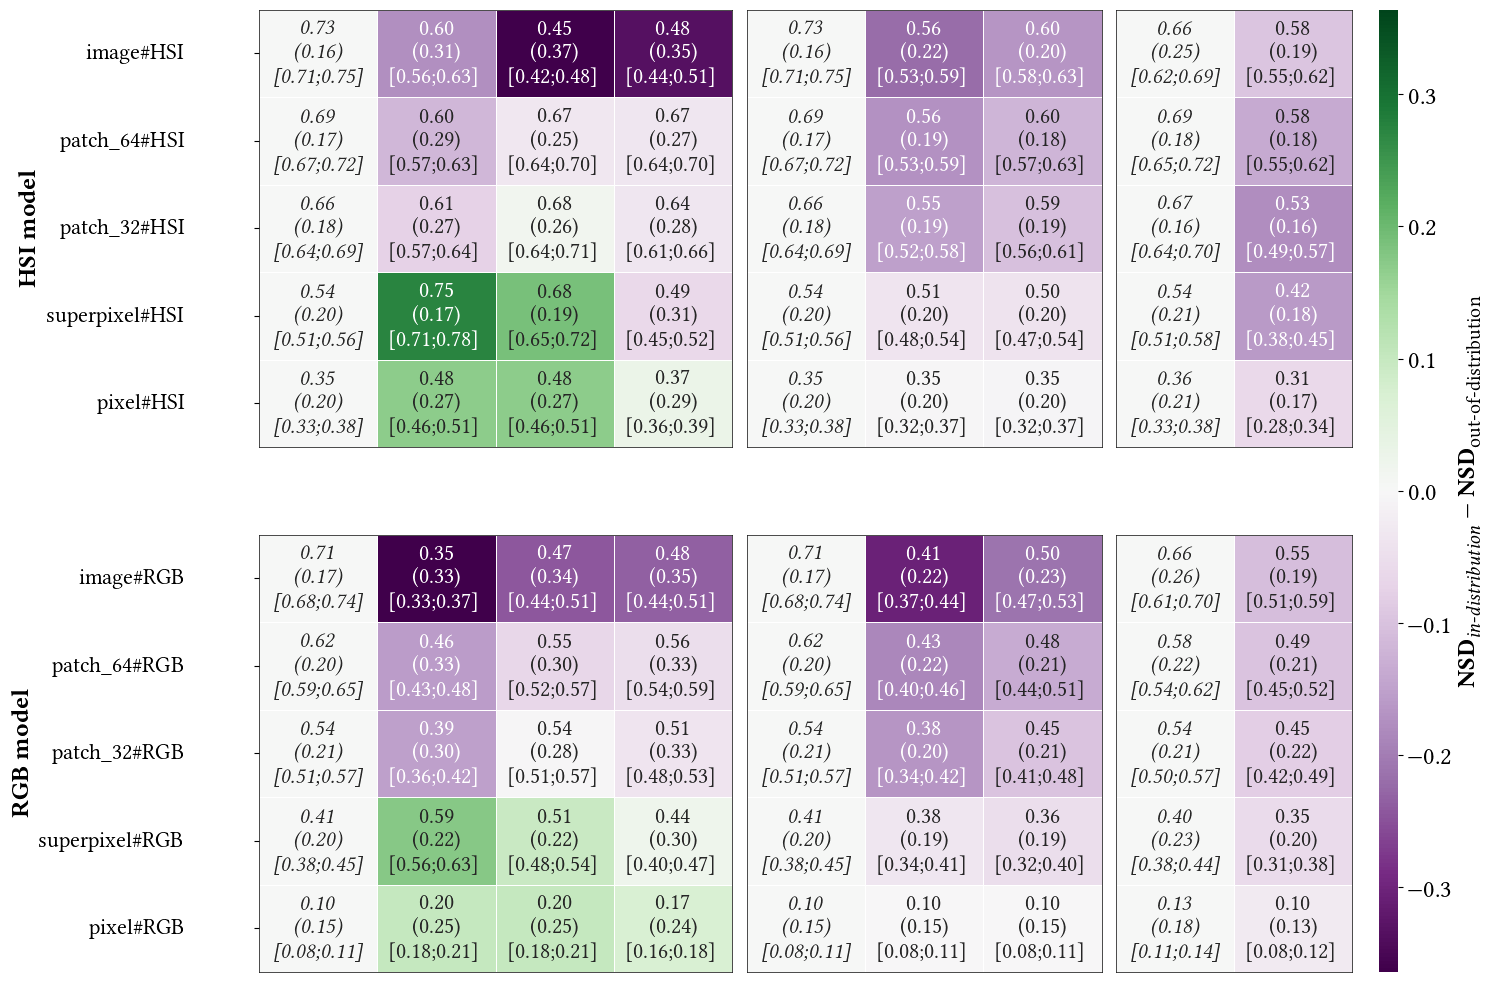

In [4]:
granularities_comparison_figure(settings_seg.nsd_aggregation_short, "NSD");